# Plant-Organelle Hunter Web implementaion

<html>
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width">
  <title>菜鸟教程</title>
</head>
<body>
<p></p>
<p>Our website https://cropopen.com/#/Cell</p>
<p>Here, we provide a more flexible local deployment for extracting morphological characteristic parameters of plant organelles</p>

</body>
</html>

First, let's simply test whether each organelle instance can be segmented individually

Download the checkpoint from the [link](https://drive.google.com/file/d/12TYv8mEUWdVqjrfbrKZK_OtcV5pq6ejr/view?usp=drive_link) or retrain a OrgSegNet model through [Train_OrgSegNet_demo](Train_OrgSegNet_demo.ipynb)

In [ ]:
!mkdir ../checkpoints
!wget https://drive.google.com/file/d/12TYv8mEUWdVqjrfbrKZK_OtcV5pq6ejr/view?usp=drive_link -P ../checkpoints

Loads checkpoint by local backend from path: ../checkpoints/OrgSegNet_iter_Version1.pth


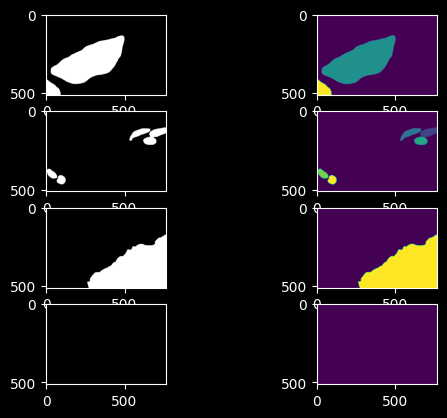

In [2]:
from utils.inference_model import Inference_the_model
imgpath = "./demo_images/demo2.tif"

config_file = "../configs/OrgSegNet/OrgSeg_PlantCell_768x512.py"
checkpoint_file = "../checkpoints/OrgSegNet_iter_Version1.pth"
# The thresholds set contain the threshold corresponds to the chloroplast, mitochondria, vacuole, and nucleus, respectively
# If there is no adhesion between organelles of the same type, the threshold is generally set to 0.5

# If two organelles of the same type stick to each other, 
# they can be adjusted within the range of [0.5, 1], generally about 0.55 to obtain better results.
#
thresholds = {
    "Chloroplast" : 0.5,
    "Mitochondrion" : 0.55,
    "Vacuole" : 0.5,
    "Nucleus" : 0.5,
}

old_img, masks, image , Instance, ori_size= Inference_the_model(imgpath, thresholds, config_file, checkpoint_file)
import matplotlib.pyplot as plt
plt.figure()

plt.subplot(4,2,1)
plt.imshow(masks['Chloroplast'])
plt.subplot(4,2,2)
plt.imshow(Instance['Chloroplast'])

plt.subplot(4,2,3)
plt.imshow(masks['Mitochondrion'])
plt.subplot(4,2,4)
plt.imshow(Instance['Mitochondrion'])


plt.subplot(4,2,5)
plt.imshow(masks['Vacuole'])
plt.subplot(4,2,6)
plt.imshow(Instance['Vacuole'])

plt.subplot(4,2,7)
plt.imshow(masks['Nucleus'])
plt.subplot(4,2,8)
plt.imshow(Instance['Nucleus'])
plt.show()

Now that we have simply tested the segmentation effect, we can run the following code to generate the same or even better segmentation results and organelle morphology indicators as in the web.

Loads checkpoint by local backend from path: ../checkpoints/OrgSegNet_iter_Version1.pth


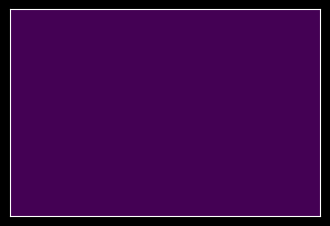

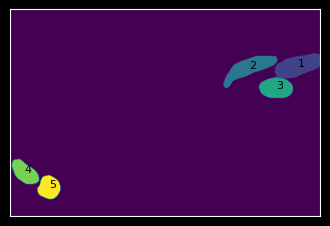

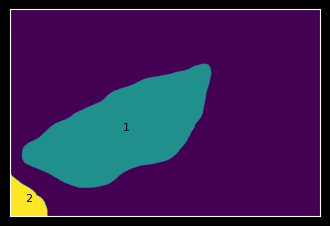

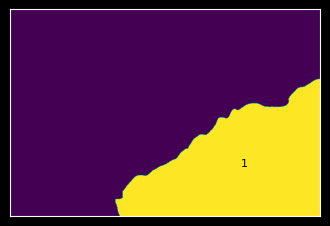

In [3]:
import os
import numpy as np
from PIL import Image

import os.path as osp
import numpy as np
from threading import Thread
from utils.intensity import get_back_intensity
import warnings
warnings.filterwarnings("ignore")
from utils.inference_model import Inference_the_model
from utils.calculate_morpho import Thread_func_get_morphological_parameter_of_organelle

def main(imgpath, rule, rule_length, work_path):
    # If you adjusted the threshold in the previous block of code, 
    # ! don't forget to modify the threshold for the best segmentation result.
    thresholds = {
        "Chloroplast" : 0.55,
        "Mitochondrion" : 0.55,
        "Vacuole" : 0.5,
        "Nucleus" : 0.5,
    }
    config_file = "../configs/OrgSegNet/OrgSeg_PlantCell_768x512.py"
    checkpoint_file = "../checkpoints/OrgSegNet_iter_Version1.pth"
    old_img, masks, image , Instance, ori_size= Inference_the_model(imgpath, thresholds, config_file, checkpoint_file)

    if os.path.exists(work_path) == False:
        os.mkdir(work_path)

    # Save a visual segmentation result
    _ = image.resize(ori_size).save(work_path + "Prediction.jpg")
    
    # Calculate the length of a pixel
    ruler_per_pixel = round(rule / rule_length, 4)
    # Get the intensity of the background
    background_intensity = get_back_intensity(old_img)
    # Convert original image to grey release image
    gray_img = np.array(old_img.convert("L"))

    # We call python's multithreading method to speed up the code
    t1 = Thread(target=Thread_func_get_morphological_parameter_of_organelle, \
        args=(work_path, "Chloroplast", Instance, background_intensity, gray_img, ruler_per_pixel, ori_size))

    t2 = Thread(target=Thread_func_get_morphological_parameter_of_organelle, \
        args=(work_path, "Mitochondrion", Instance, background_intensity,  gray_img, ruler_per_pixel, ori_size))

    t3 = Thread(target=Thread_func_get_morphological_parameter_of_organelle, \
        args=(work_path, "Vacuole", Instance, background_intensity, gray_img, ruler_per_pixel, ori_size))
        
    t4 = Thread(target=Thread_func_get_morphological_parameter_of_organelle, \
        args=(work_path, "Nucleus", Instance, background_intensity, gray_img, ruler_per_pixel, ori_size))

    t1.start()
    t2.start()
    t3.start()
    t4.start()

    t1.join()
    t2.join()
    t3.join()
    t4.join()

if __name__ == '__main__':
    # Set the img path
    imgpath = "./demo_images/demo2.tif"
    
    # Manually get image scale and scale length
    rule = 1  # um   1um=1000nm
    rule_length = 420  # 420 pixels

    # set the work path where the results will be saved
    work_path = "./work_dirs/test/"

    # run the main function to generate the results
    main(imgpath , rule, rule_length, work_path)
